Plan:
- Data analysis:
    - Data visualization and exploration(means, medians etc.), analyse distributions 
    - Dealing with NaN values
    - Dealing with imbalanced dataset
- Feature Engineering (Feature selection):
    - Find correlation matrix in order to calculate least useful features that do not corelate with the output 
    - Perform a dimesion reduction:
        - Label encoding for categorical variables
        - Feature scaling: data normalization
        - Filter methods (information gain)
        - PCA
        - Heatmap, t-SNE, Multi-Dimensional Scaling(MDS)
- Data splitting
- Selecting ML algorithm
- Regularization
- Hyperparameter tuning
- Saving the model

Notes:
<br>After looking at the data I have come to conclusion that the amount of features is big, so I decided to perform feature selection at first and then do some Feature engineering. Also the categorical variables seems not encoded and there are way too many categories in some features. There are also a lot of NaN values and I need to pick one of the methods to replace them.
<br>
<br>
Make plan less detailed and describe my thoughts during process

## 0. Install dependencies

In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np

from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler



## 1. Load data

In [2]:
df = pd.read_csv("./train_df.csv", sep='\t')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26824 entries, 0 to 26823
Columns: 554 entries, Unnamed: 0 to gb
dtypes: float64(416), int64(138)
memory usage: 113.4 MB
None
   Unnamed: 0   num_1   num_2  num_3   num_4   num_5   num_6  num_7  cat_1  \
0           0  1377.3  3712.9    NaN  1303.0  2409.0  1281.7   43.0      1   
1           1    20.0    13.4    NaN   565.0     NaN   357.2   19.0      1   
2           4   150.6     1.8    NaN  2294.0    15.0   107.6   76.0      1   
3           5    11.4   178.0    NaN  1236.0     NaN   350.6   41.0      1   
4           6  5372.0  3386.0    NaN  1340.0     NaN    14.0   45.0      1   

   num_8  ...  num_413  cat_132  cat_133      num_414  num_415  num_416  \
0  195.0  ...  11327.5        1        1  28162496.65      0.0     0.07   
1  170.0  ...    168.6        1        1    989383.82      0.0     0.56   
2  196.0  ...    209.1        1        1     87444.51      0.0     0.01   
3  117.0  ...     56.9        1        1    297608.00  

In [3]:
repetitive_id = df['id'].duplicated()
print(len(df[repetitive_id==True]))

21581


In [4]:
print(df.loc[df["id"]==4320]) # take as an example id number 4320 and analyse if all the variables are the same

       Unnamed: 0  num_1  num_2  num_3   num_4  num_5  num_6  num_7  cat_1  \
17121       37793    4.2   97.2    NaN  2090.0  130.5  409.3   70.0      1   
19880       44433    4.2   97.2    NaN  2121.0  130.5  409.3   71.0      1   
26820       61105    4.2   97.2    NaN  2149.0  130.5  409.3   72.0      1   

       num_8  ...  num_413  cat_132  cat_133     num_414  num_415  num_416  \
17121   98.0  ...    596.7        1        1  1089878.89      0.0     0.11   
19880  129.0  ...    596.7        1        1   782974.94      0.0     0.17   
26820  157.0  ...    596.7        1        1   557554.94      0.0     0.26   

       cat_134  cat_135    id  gb  
17121        5        1  4320   0  
19880        5        1  4320   0  
26820        5        1  4320   0  

[3 rows x 554 columns]


As we can see the id may be repetitive and it means that one person may be present in dataframe various times. However, the data of the columns is not always the same and some of the features may change.
<br>The id value may not be as important as the amout of its occurance in dataframe for the future model, so we can create a new column that indicates how many times id was seen in the dataframe before.
<br>We won't use id column as the training data as well as the result (gb), so I will move these values to another dataframes

In [5]:
data = df.drop(['gb','id'],axis=1)
labels = df['gb']
ids = df['id']

In [6]:
data['num_cust_1'] = df.groupby('id').cumcount() + 1 # create new custom column (feature engineering)

In [7]:
print("New feature column:")
print(data['num_cust_1'])

New feature column:
0        1
1        1
2        1
3        1
4        1
        ..
26819    1
26820    3
26821    8
26822    2
26823    1
Name: num_cust_1, Length: 26824, dtype: int64


In [8]:
print("Balance of target value:")
print(str(len(labels)) + " rows = 100%")
for value in labels.unique():
    print("Number of " + str(value) +":")
    print(str(labels[labels==value].count()) +" rows = " + str((labels[labels==value].count()*100/len(labels))) +"%")


Balance of target value:
26824 rows = 100%
Number of 0:
26231 rows = 97.78929317029525%
Number of 1:
593 rows = 2.210706829704742%


The output value (target value) is very impalanced. There are several techniques to deal with this, I am going to use Synthetic Minority Oversampling Technique (SMOTE)
<br>
<br>[info](https://medium.com/metaor-artificial-intelligence/solving-the-class-imbalance-problem-58cb926b5a0f#:~:text=Imbalanced%20classification%20is%20a%20common,bias%20in%20the%20trained%20model.)
<br>[more usefull info](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In order to use SMOTE, we need to find a way to deal with NaN values. The main problem is that I don't know the origin of these features nor their names, so I would use KNNImputer.

First of all lets drop all the columns that have >80% NaN values and correlation < 0.08, so we can focus on important columns with enough data to work with

In [9]:
nan_columns = []
for column in df.columns:
    if (df[column].isna().sum())*100/len(df[column]) >=80:
        nan_columns.append(column)

In [10]:
for column in nan_columns:
    print("There are " + str(df[column].notna().sum()) + f" not NaN values in column {column} and amount of '1' under this condition is " + str(sum(df[df[column].notna()]["gb"]))+ ", correlation: "+str(abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])))

There are 63 not NaN values in column num_3 and amount of '1' under this condition is 0, correlation: nan
There are 36 not NaN values in column num_11 and amount of '1' under this condition is 0, correlation: nan
There are 535 not NaN values in column num_18 and amount of '1' under this condition is 0, correlation: nan
There are 445 not NaN values in column num_20 and amount of '1' under this condition is 0, correlation: nan
There are 62 not NaN values in column num_21 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_22 and amount of '1' under this condition is 0, correlation: nan
There are 0 not NaN values in column num_23 and amount of '1' under this condition is 0, correlation: nan
There are 1 not NaN values in column num_24 and amount of '1' under this condition is 0, correlation: nan
There are 799 not NaN values in column num_25 and amount of '1' under this condition is 78, correlation: 0.025660684954407487
There are 2459 not N

There are 1140 not NaN values in column num_65 and amount of '1' under this condition is 6, correlation: 0.02195028787731583
There are 0 not NaN values in column num_66 and amount of '1' under this condition is 0, correlation: nan
There are 445 not NaN values in column num_73 and amount of '1' under this condition is 0, correlation: nan
There are 4208 not NaN values in column num_78 and amount of '1' under this condition is 107, correlation: 0.013764095135697443
There are 466 not NaN values in column num_82 and amount of '1' under this condition is 7, correlation: 0.010284431637767724
There are 4 not NaN values in column num_86 and amount of '1' under this condition is 0, correlation: nan
There are 151 not NaN values in column num_89 and amount of '1' under this condition is 4, correlation: 0.04257946503632065
There are 149 not NaN values in column num_90 and amount of '1' under this condition is 0, correlation: nan
There are 110 not NaN values in column num_91 and amount of '1' under 

In [11]:
for column in nan_columns:
    if column in data.columns:
        if abs(df.loc[df[column].notna(), [column, 'gb']].corr().iloc[0, 1])<0.08:
            print(column + " dropped")
            data = data.drop(column, axis=1)

num_25 dropped
num_35 dropped
num_36 dropped
num_37 dropped
num_39 dropped


num_46 dropped
num_47 dropped
num_56 dropped
num_61 dropped
num_63 dropped
num_65 dropped
num_78 dropped
num_82 dropped
num_89 dropped
num_93 dropped
num_96 dropped
num_100 dropped
num_109 dropped
num_116 dropped
num_118 dropped
num_126 dropped
num_127 dropped
num_146 dropped
num_163 dropped
num_182 dropped
num_199 dropped
num_208 dropped
num_224 dropped
num_236 dropped
num_241 dropped
num_245 dropped
num_247 dropped
num_249 dropped
num_251 dropped
num_273 dropped
num_278 dropped
num_280 dropped
num_286 dropped
num_291 dropped
num_295 dropped
num_297 dropped
num_302 dropped
num_316 dropped
num_326 dropped
num_333 dropped
num_337 dropped
num_343 dropped
num_368 dropped
num_374 dropped
num_377 dropped
num_388 dropped
num_394 dropped
num_399 dropped
num_403 dropped


In [12]:
print(len(data.columns))

499


Skipping features without any observed values

In [13]:
rows = len(data)
for column in data.columns:
    if sum(data[column].isna())==rows:
        data = data.drop(column, axis=1)

In [14]:
print(len(data.columns))

487


(explain why I chose KNNImputer)

In [124]:
impute_knn = KNNImputer(n_neighbors=2)
data_imputed = impute_knn.fit_transform(data)

In [26]:
dataframe_updated = pd.DataFrame(data_imputed, columns=data.columns)

In [29]:
for column in dataframe_updated.columns:
    if column.find("cat")!=-1:
        dataframe_updated[column] = dataframe_updated[column].astype(int)


Make all columns with categorical values int, so if KNNImputer replaced NaN with float value it turned into int

In [30]:
dataframe_updated.to_csv('updated_df.csv',index=False)

Dealing with class imbalance

In [31]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(dataframe_updated, labels)


c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [32]:
print("Balance of target value:")
print(str(len(x_smote)) + " rows = 100%")
for value in y_smote.unique():
    print("Number of " + str(value) +":")
    print(str(y_smote[y_smote==value].count()) +" rows = " + str((y_smote[y_smote==value].count()*100/len(y_smote))) +"%")


Balance of target value:
52462 rows = 100%
Number of 0:
26231 rows = 50.0%
Number of 1:
26231 rows = 50.0%


Problem with class imbalance is solved with synthetic oversampling

## 2. Analyze Data

The amount of features is still big enough. Lets drop all the columns that have correlation with target value < 0.03 using correlation matrix

In [33]:

full_df = pd.concat([x_smote, y_smote], axis=1)


In [34]:
print(full_df)

         Unnamed: 0        num_1        num_2        num_3        num_4  \
0          0.000000  1377.300000  3712.900000  3563.000000  1303.000000   
1          1.000000    20.000000    13.400000    76.000000   565.000000   
2          4.000000   150.600000     1.800000    76.000000  2294.000000   
3          5.000000    11.400000   178.000000    76.000000  1236.000000   
4          6.000000  5372.000000  3386.000000   265.000000  1340.000000   
...             ...          ...          ...          ...          ...   
52457  23921.123520    10.800000   205.500000    76.000000  2389.936126   
52458  13839.877998    32.248762   147.768908   217.183907  1668.100837   
52459  31562.160862  2316.014764   988.989322    41.901966   101.288342   
52460  46084.780810   170.900000   451.200000    76.000000  1295.685743   
52461  49099.530416   244.747245   159.080055    13.000000  1491.893045   

             num_5        num_6      num_7  cat_1       num_8  ...  \
0      2409.000000  1281.7000

In [35]:
corr_matrix = full_df.corr()
# sn.heatmap(corr_matrix, annot=True) # hard to read due to big amount of columns
# plt.show()


In [37]:
print(len(full_df.loc[:,abs(corr_matrix.loc["gb"])>0.03].columns))
full_df = (full_df.loc[:,abs(corr_matrix.loc["gb"])>0.03])
print(len(full_df.columns))

310
310


In [39]:
full_df.to_csv("updated_df.csv", index=False)

### 2.1 Data Exploration

First let's analyze categorical features. Maybe we would find a way to encode them or find hidden patterns.
<br>
<br>Extracting categorical features:

In [40]:
categorical = []
for column in full_df.columns:
    if column.find("cat")!=-1:
        categorical.append(column)
    df_categorical = full_df[categorical]
        

Descriptive Statistics

Statistics from all columns:

Max variance: 88670.00497805512


Min variance: 0.0014473871810073188
Max max-value: 1461
Min max-value: 2
Max min-value: 1
Min min-value: 1
Max mean: 354.5498456025314
Min mean: 1.0011436849529183
Max median: 281.0
Min median: 1.0


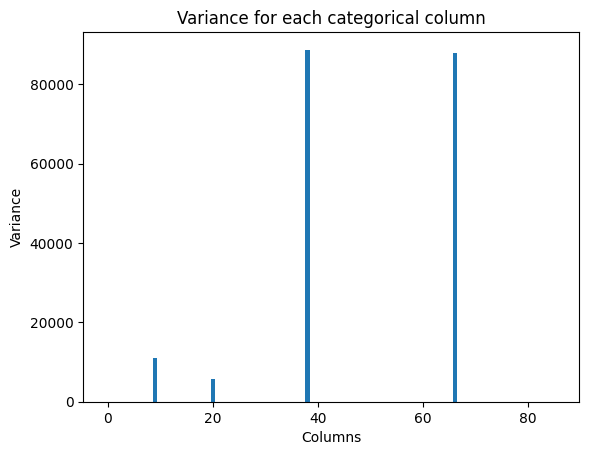

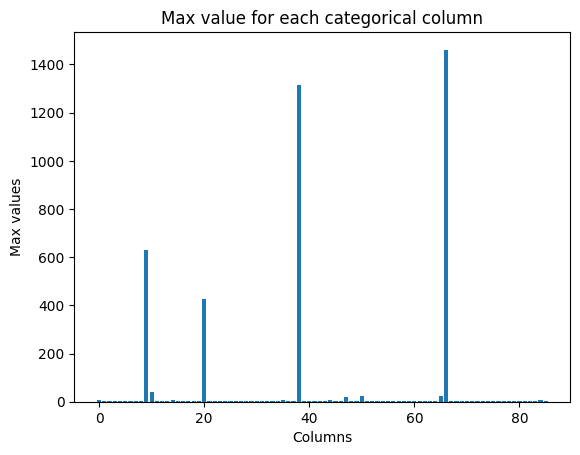

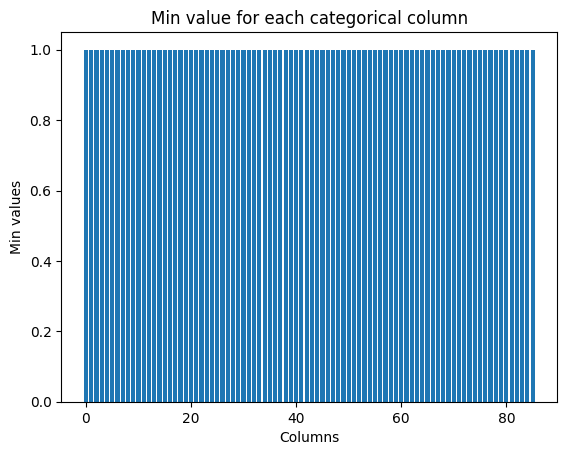

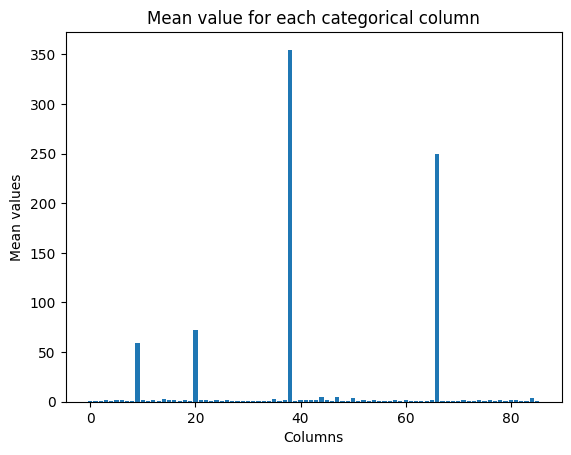

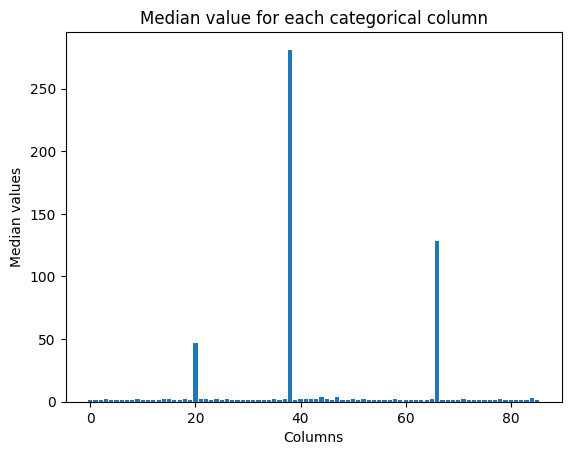

In [42]:
print("Statistics from all columns:\n")
plt.figure(1)
 
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each categorical column")
print("Max variance: " + str(max(df_categorical.var())))
print("Min variance: " + str(min(df_categorical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each categorical column")
print("Max max-value: " + str(max(df_categorical.max())))
print("Min max-value: " + str(min(df_categorical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each categorical column")
print("Max min-value: " + str(max(df_categorical.min())))
print("Min min-value: " + str(min(df_categorical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each categorical column")
print("Max mean: " + str(max(df_categorical.mean())))
print("Min mean: " + str(min(df_categorical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_categorical.columns))], df_categorical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each categorical column")
print("Max median: " + str(max(df_categorical.median())))
print("Min median: " + str(min(df_categorical.median())))

plt.show()


Some of the categorical features have way too more classes, on the other hand, most of the features has maximum 10 different classes and the most popular are the first classes (median of all median proves this)

In [43]:
print(df_categorical.median().median())

1.0


As we can see, the median of all medians is 1, that means than most of the categorical values equal to 1.<br>
Let's analyse the distribution for some of the features

Lets display distribution of features with high variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

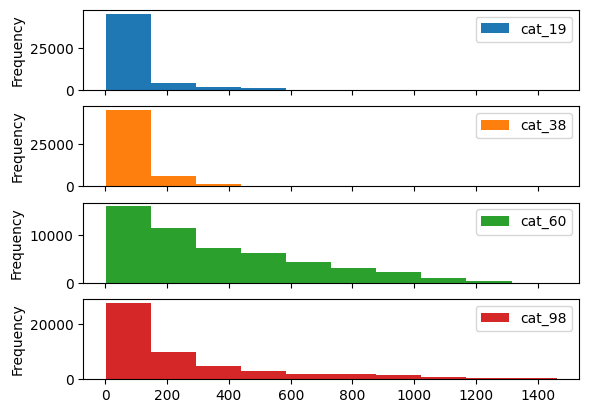

In [44]:
df_categorical.loc[:,df_categorical.var()>100].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

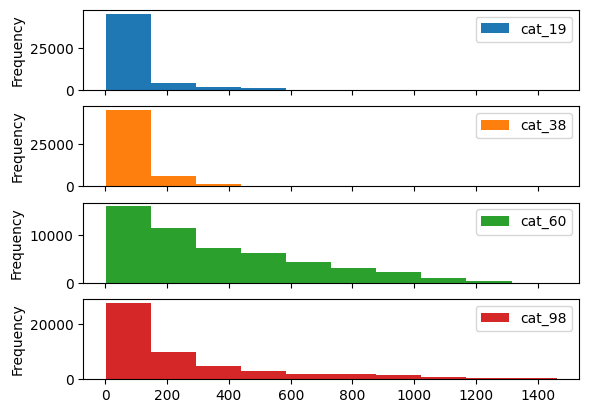

In [45]:
df_categorical.loc[:,df_categorical.max()>100].plot(kind='hist',subplots=True)

Now display distribution of features with low variance and max values

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

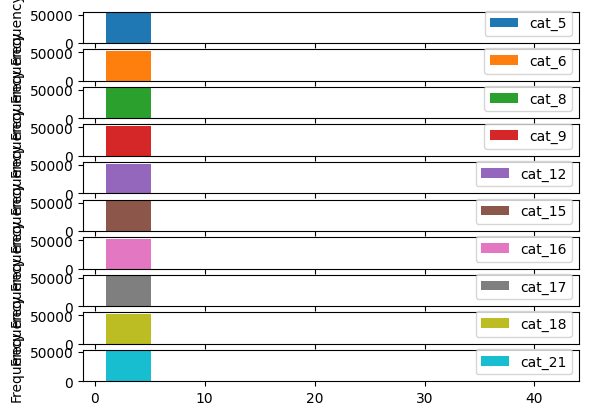

In [46]:
df_categorical.loc[:,df_categorical.var()<10].iloc[:, :10].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

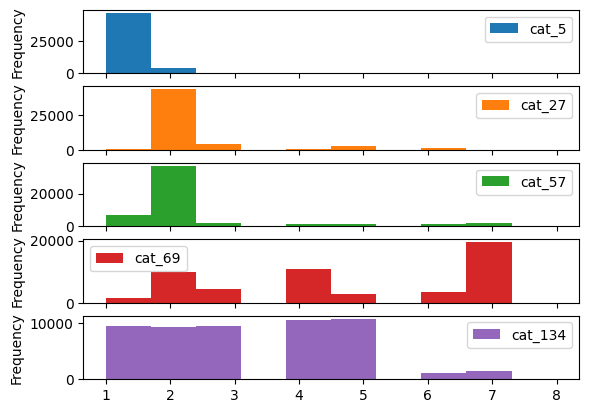

In [47]:
df_categorical.loc[:,(df_categorical.max() > 5) & (df_categorical.max() < 10)].iloc[:, :20].plot(kind='hist',subplots=True)

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

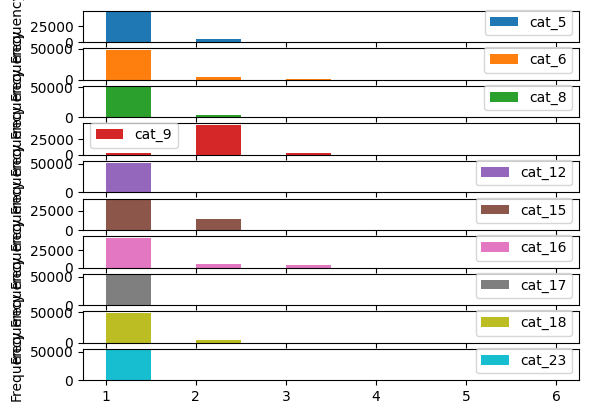

In [48]:
df_categorical.loc[:,df_categorical.max() < 15].iloc[:, :10].plot(kind='hist',subplots=True)

As we can see all features mostly consist of first classes. Columns with wide range of values have more variance and max values meanwhile features with low amount of classes behave differently

In [49]:
numerical = []
for column in full_df.columns:
    if column.find("cat")==-1:
        numerical.append(column)
    df_numerical = full_df[numerical]
        

Statistics from all columns:



Max variance: 1.961165353253059e+22
Min variance: 0.014297738340041029
Max max-value: 4205800000000.0
Min max-value: -39.0
Max min-value: 1000.0
Min min-value: -1578869000000.0
Max mean: 11088905528.654516
Min mean: -1163707.205102404
Max median: 3108760.3803327074
Min median: -538337.3907409357


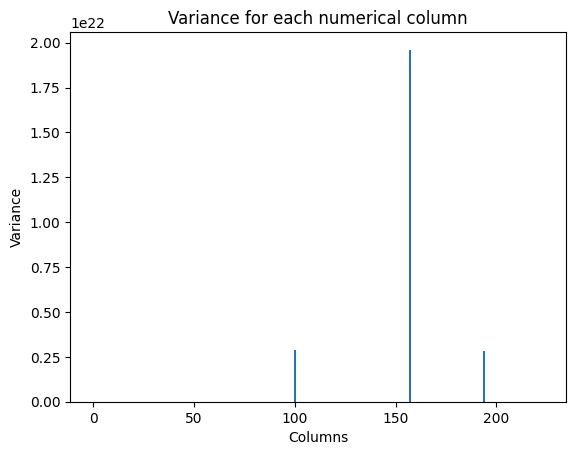

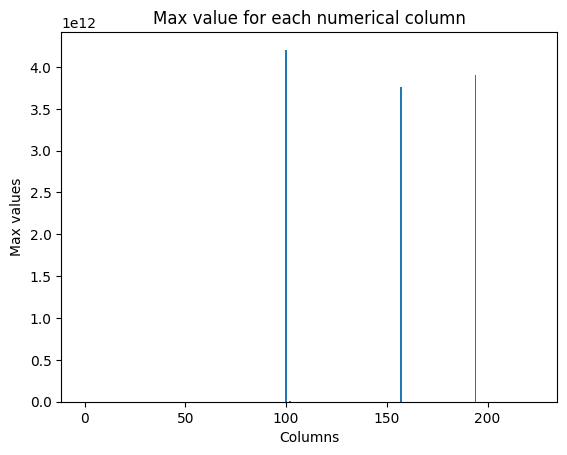

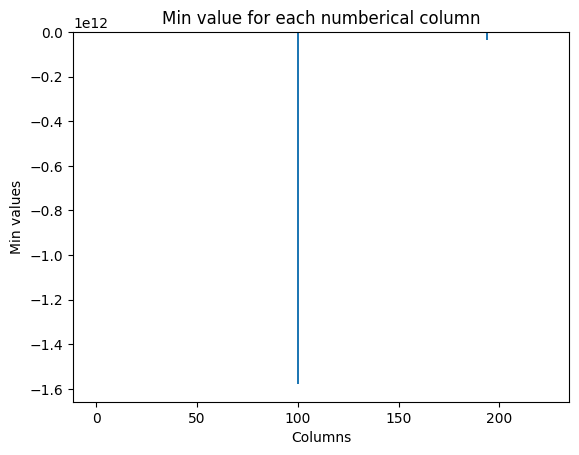

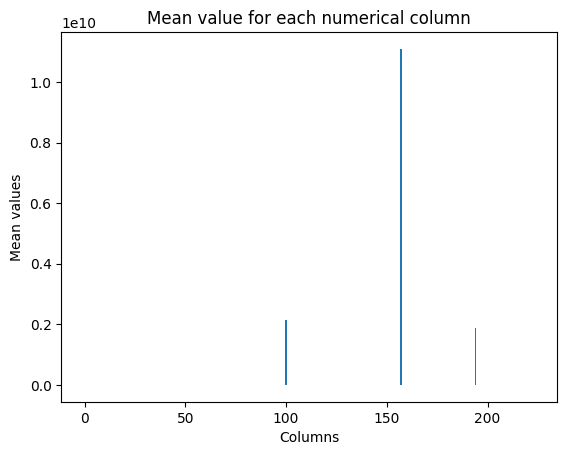

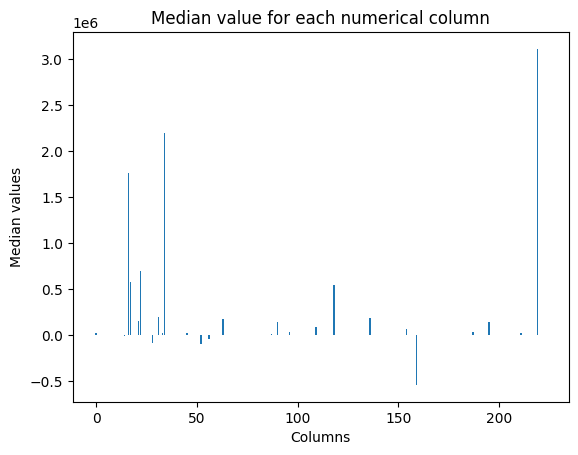

In [50]:
print("Statistics from all columns:\n")

plt.figure(1)
 
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.var())
plt.xlabel("Columns")
plt.ylabel("Variance")
plt.title("Variance for each numerical column")
print("Max variance: " + str(max(df_numerical.var())))
print("Min variance: " + str(min(df_numerical.var())))

plt.figure(2)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.max())
plt.xlabel("Columns")
plt.ylabel("Max values")
plt.title("Max value for each numerical column")
print("Max max-value: " + str(max(df_numerical.max())))
print("Min max-value: " + str(min(df_numerical.max())))

plt.figure(3)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.min())
plt.xlabel("Columns")
plt.ylabel("Min values")
plt.title("Min value for each numberical column")
print("Max min-value: " + str(max(df_numerical.min())))
print("Min min-value: " + str(min(df_numerical.min())))

plt.figure(4)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.mean())
plt.xlabel("Columns")
plt.ylabel("Mean values")
plt.title("Mean value for each numerical column")
print("Max mean: " + str(max(df_numerical.mean())))
print("Min mean: " + str(min(df_numerical.mean())))

plt.figure(5)
plt.bar([i for i in range(0,len(df_numerical.columns))], df_numerical.median())
plt.xlabel("Columns")
plt.ylabel("Median values")
plt.title("Median value for each numerical column")
print("Max median: " + str(max(df_numerical.median())))
print("Min median: " + str(min(df_numerical.median())))

plt.show()


In [51]:
print(df_numerical.median().median())

59.89529268320025


Numerical data behaves similary to categorical, but have more variance, median, mean etc. <br>
Some of features may contain outliers, but they seem to be useful and don't affect much on global picture. 

## 3. Feature Selection

Let's use dataset after all the previous changes and discover whether we can reduce amount of features in order to make ML model learn better

In [39]:
dataframe_updated = pd.read_csv("./updated_df.csv")

In [40]:
print(len(dataframe_updated))

52462


In [41]:
print(dataframe_updated.describe())

         Unnamed: 0         num_1         num_2          num_3         num_4  \
count  52462.000000  5.246200e+04  5.246200e+04   52462.000000  52462.000000   
mean   28915.649290  2.617220e+03  2.954653e+03     855.852769   1123.645601   
std    16735.338821  3.785952e+04  5.064936e+04    8325.618843    713.807709   
min        0.000000  1.000000e-01  1.000000e-01      12.000000     13.000000   
25%    14428.883813  2.950000e+01  1.910000e+01      48.000000    518.000000   
50%    28429.210992  1.379000e+02  8.787942e+01      76.000000    976.674736   
75%    42974.112203  7.005000e+02  4.129930e+02      76.000000   1691.000000   
max    61111.000000  2.611006e+06  2.410354e+06  163155.000000   2660.000000   

              num_6         num_7        num_11        num_12        num_13  \
count  5.246200e+04  52462.000000  52462.000000  52462.000000  52462.000000   
mean   9.757719e+03     37.458660   1128.118081    223.543437    250.693322   
std    9.887811e+04     23.796723   1174.2

In [42]:
data_updated = dataframe_updated.drop(['gb'],axis=1)
labels_updated = dataframe_updated['gb']

may use:
- Filter methods (Pearson’s correlation and Chi-Squared test)
- Linear algebra: PCA
- Manifold Learning: MDS, t-SNE
- wrapper feature selection method.
<br>
<br>
Typically, linear algebra and manifold learning methods assume that all input features have the same scale or distribution. This suggests that it is good practice to either normalize or standardize data prior to using these methods if the input variables have differing scales or units. Also normalization would improve ML model performance

Before normalizing or standardizing data I need to encode labels for categorical variables. Unfortunutely, I don't know if the variables are nominal or ordinal nor the meaning of the features, so i will assume the original data is already encoded with "Label Encoding" as it is already described numerically.

In [43]:
# fit scaler on training data
norm = MinMaxScaler().fit(data_updated)

# transform data
X_normalized = norm.transform(data_updated)

In [44]:
X_normalized = pd.DataFrame(X_normalized, columns=data_updated.columns)
print(X_normalized)

       Unnamed: 0     num_1         num_2     num_3     num_4     num_6  \
0        0.000000  0.000527  1.540355e-03  0.021766  0.487344  0.057718   
1        0.000016  0.000008  5.517862e-06  0.000392  0.208538  0.057495   
2        0.000065  0.000058  7.052906e-07  0.000392  0.861730  0.057434   
3        0.000082  0.000004  7.380659e-05  0.000392  0.462032  0.057493   
4        0.000098  0.002057  1.404731e-03  0.001551  0.501322  0.057412   
...           ...       ...           ...       ...       ...       ...   
52457    0.391437  0.000004  8.521570e-05  0.000392  0.897974  0.057458   
52458    0.226471  0.000012  6.126441e-05  0.001258  0.625274  0.057416   
52459    0.516473  0.000887  4.102673e-04  0.000183  0.033354  0.057608   
52460    0.754116  0.000065  1.871509e-04  0.000392  0.484581  0.057392   
52461    0.803448  0.000094  6.595714e-05  0.000006  0.558705  0.057618   

          num_7    num_11    num_12    num_13  ...   num_410   num_411  \
0      0.483146  0.000780

Firstly, lets get feature importance scores through information gain

In [45]:
ig = mutual_info_regression(X_normalized, labels_updated)

Feature: num_7 Score: 0.6106503482038725
Feature: num_301 Score: 0.6097420210204909
Feature: num_214 Score: 0.6038403447694396
Feature: num_235 Score: 0.5987220986882225
Feature: num_132 Score: 0.5978893622074839
Feature: num_187 Score: 0.5834166170816317
Feature: num_97 Score: 0.5637437770998712
Feature: num_206 Score: 0.5620978522739009
Feature: num_202 Score: 0.554766229457508
Feature: num_159 Score: 0.5334015281135933
Feature: num_cust_1 Score: 0.5307235373661765
Feature: num_26 Score: 0.5244955742196638
Feature: num_13 Score: 0.5210705532665845
Feature: num_304 Score: 0.5054867675262784
Feature: num_275 Score: 0.49640655183880433
Feature: num_173 Score: 0.46800996954573115
Feature: num_225 Score: 0.46111124469916476
Feature: num_75 Score: 0.45439939818170316
Feature: num_4 Score: 0.4504711821802285
Feature: num_172 Score: 0.4446687473476789
Feature: num_232 Score: 0.4438383384393916
Feature: num_234 Score: 0.44284296943576074
Feature: num_129 Score: 0.4424207963384923
Feature: num

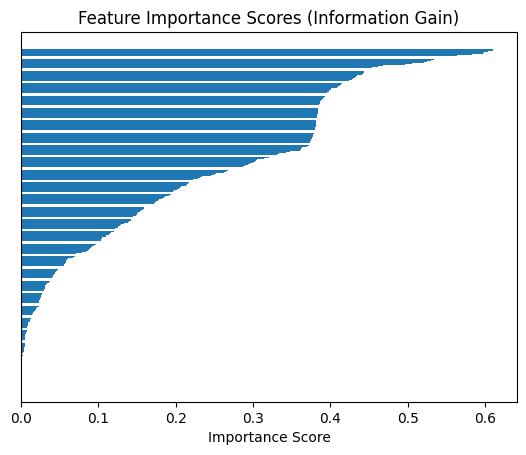

In [53]:
# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X_normalized.columns)):
    feature_scores[X_normalized.columns[i]] = ig[i]
# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)
# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots()
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center")
ax.set_yticks([])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")
plt.show()


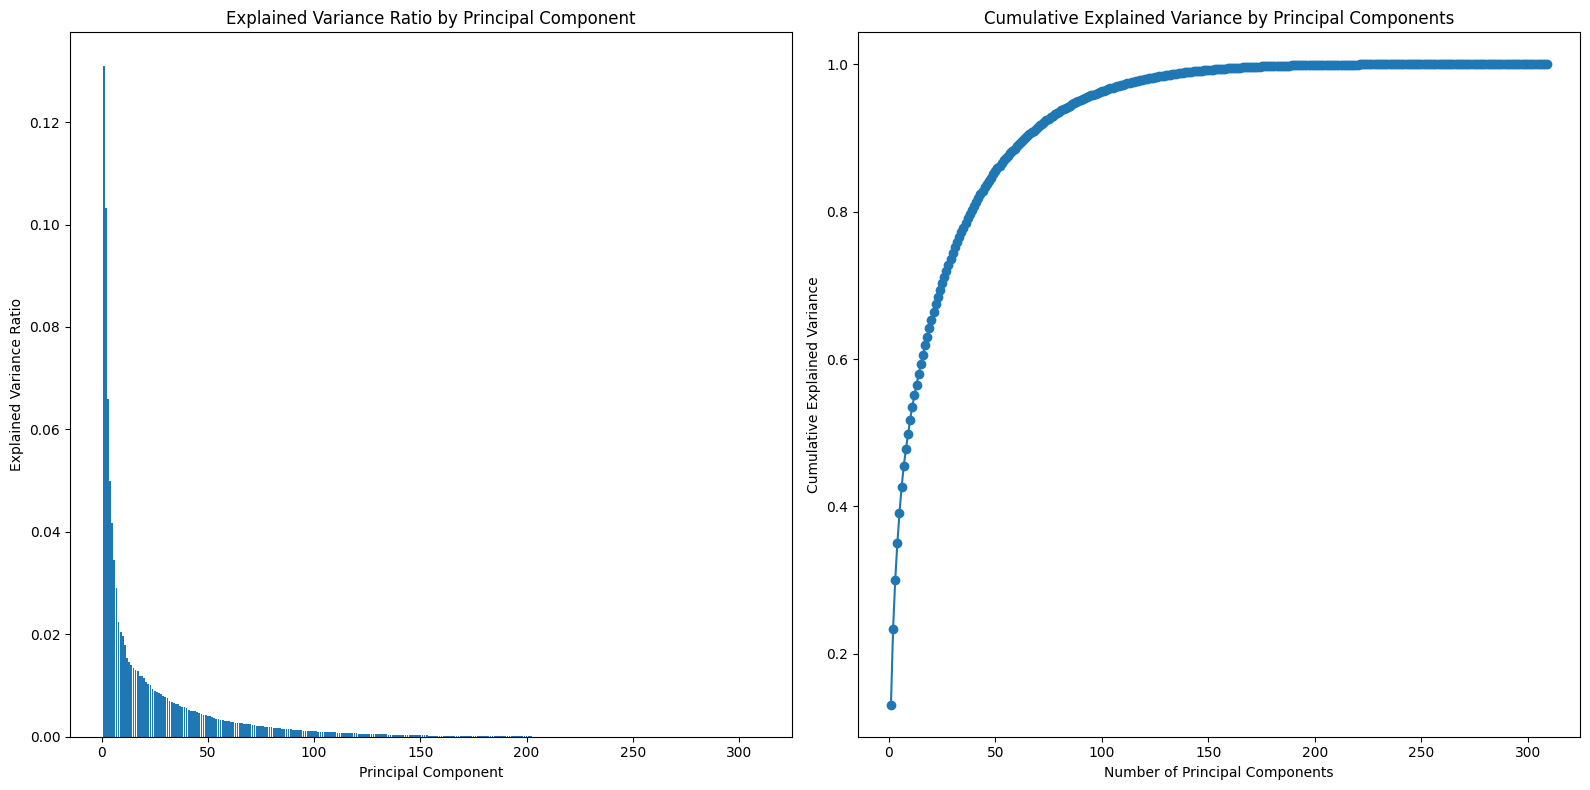

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_names = X_normalized.columns

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the explained variance ratio in the first subplot
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
ax1.set_xlabel("Principal Component")
ax1.set_ylabel("Explained Variance Ratio")
ax1.set_title("Explained Variance Ratio by Principal Component")

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance in the second subplot
ax2.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
)
ax2.set_xlabel("Number of Principal Components")
ax2.set_ylabel("Cumulative Explained Variance")
ax2.set_title("Cumulative Explained Variance by Principal Components")

# Display the figure
plt.tight_layout()
plt.show()


After consideration I have decided not to use PCA and other unsupervised techniques since we already have target value and we need to leave the most useful values to make model more understandable, meanwhile unsupervised techniques compress the dimensions and try to make the data as much representative as possible

Let's delete features that have less than 0.15 information gain

In [70]:
for feature, score in sorted_features:
    if score<0.15:
        X_normalized = X_normalized.drop(feature, axis=1)
        print(feature + " dropped")

num_292 dropped
num_144 dropped
num_58 dropped
num_138 dropped
num_11 dropped
num_348 dropped
num_149 dropped
num_253 dropped
num_166 dropped
num_227 dropped
num_276 dropped
num_260 dropped
num_121 dropped
num_171 dropped
num_105 dropped
num_164 dropped
num_115 dropped
cat_38 dropped
num_217 dropped
cat_98 dropped
num_341 dropped
num_231 dropped
num_354 dropped
num_271 dropped
num_51 dropped
num_133 dropped
cat_68 dropped
num_350 dropped
num_67 dropped
num_169 dropped
num_252 dropped
num_198 dropped
num_201 dropped
num_205 dropped
num_334 dropped
num_415 dropped
num_184 dropped
cat_27 dropped
cat_19 dropped
num_233 dropped
num_212 dropped
num_88 dropped
num_216 dropped
num_32 dropped
num_298 dropped
num_308 dropped
num_162 dropped
num_336 dropped
num_119 dropped
num_366 dropped
num_194 dropped
num_53 dropped
cat_15 dropped
num_62 dropped
num_395 dropped
num_414 dropped
num_29 dropped
num_122 dropped
cat_21 dropped
num_130 dropped
cat_125 dropped
cat_73 dropped
num_190 dropped
cat_92 dr

In [72]:
print(X_normalized.shape)

(52462, 151)


In [74]:
full_df = pd.concat([X_normalized, labels_updated], axis=1)

In [76]:
full_df.to_csv("selected_df.csv", index=False)

## 4. Model selection

In [34]:
full_df =pd.read_csv("selected_df.csv")

In [16]:
print(full_df)

          num_1         num_2     num_3     num_4     num_6     num_7  \
0      0.000527  1.540355e-03  0.021766  0.487344  0.057718  0.483146   
1      0.000008  5.517862e-06  0.000392  0.208538  0.057495  0.213483   
2      0.000058  7.052906e-07  0.000392  0.861730  0.057434  0.853933   
3      0.000004  7.380659e-05  0.000392  0.462032  0.057493  0.460674   
4      0.002057  1.404731e-03  0.001551  0.501322  0.057412  0.505618   
...         ...           ...       ...       ...       ...       ...   
52457  0.000004  8.521570e-05  0.000392  0.897974  0.057458  0.894801   
52458  0.000012  6.126441e-05  0.001258  0.625274  0.057416  0.626909   
52459  0.000887  4.102673e-04  0.000183  0.033354  0.057608  0.033816   
52460  0.000065  1.871509e-04  0.000392  0.484581  0.057392  0.480551   
52461  0.000094  6.595714e-05  0.000006  0.558705  0.057618  0.554800   

         num_12    num_13    num_19    num_20  ...       num_401   num_404  \
0      0.005270  0.115068  0.002022  0.184426

In [35]:
Y = full_df["gb"]
X = full_df.drop("gb",axis=1)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [36]:
X_t, X_test, Y_t, y_test = train_test_split(X, Y, test_size=0.8, random_state=42)


In [23]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}


In [24]:
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_t, Y_t)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name}: Accuracy = {accuracy:.4f}")


c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.8315
SVC: Accuracy = 0.9158
Decision Tree: Accuracy = 0.9517
Random Forest: Accuracy = 0.9970


Decision Tree and Random Forest seems to be overfitted, so I will focus on SVC and Logistic Regression

### 4.1 Regularization

SVM using regularization:

In [37]:
# standartize data before regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_t)
X_test_scaled = scaler.transform(X_test)

regularization_parameter = 1.0  

model = SVC(kernel='linear', C=regularization_parameter)
model.fit(X_train_scaled, Y_t)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("Classification Report:\n", classification_report_str)


Accuracy: 0.8537
Confusion Matrix:
[[16848  4067]
 [ 2074 18981]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85     20915
           1       0.82      0.90      0.86     21055

    accuracy                           0.85     41970
   macro avg       0.86      0.85      0.85     41970
weighted avg       0.86      0.85      0.85     41970



Logistic Regression using regularization:

In [33]:
# standartize data before regularization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_t)
X_test = scaler.transform(X_test)

regularization_parameter = 1.0

logreg_model = LogisticRegression(C=regularization_parameter)
logreg_model.fit(X_train, Y_t)

y_pred_logreg = logreg_model.predict(X_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

print("Logistic Regression:")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_logreg}")
print("Classification Report:\n", classification_report_logreg)


Logistic Regression:
Accuracy: 0.8418
Confusion Matrix:
[[17093  3822]
 [ 2818 18237]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84     20915
           1       0.83      0.87      0.85     21055

    accuracy                           0.84     41970
   macro avg       0.84      0.84      0.84     41970
weighted avg       0.84      0.84      0.84     41970



c:\Users\Tymof\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.2 Hyperparameter tuning

SVM seems to be working better. Lets try some Hyperparameter tuning

In [38]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
for c in C_values:
    model = SVC(kernel='linear', C=c)
    model.fit(X_train_scaled, Y_t)

    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred)

    print(f"C: {c}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("Classification Report:\n", classification_report_str)
    

C: 0.001
Accuracy: 0.8275
Confusion Matrix:
[[15938  4977]
 [ 2262 18793]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81     20915
           1       0.79      0.89      0.84     21055

    accuracy                           0.83     41970
   macro avg       0.83      0.83      0.83     41970
weighted avg       0.83      0.83      0.83     41970

C: 0.01
Accuracy: 0.8399
Confusion Matrix:
[[16409  4506]
 [ 2213 18842]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83     20915
           1       0.81      0.89      0.85     21055

    accuracy                           0.84     41970
   macro avg       0.84      0.84      0.84     41970
weighted avg       0.84      0.84      0.84     41970

C: 0.1
Accuracy: 0.8472
Confusion Matrix:
[[16703  4212]
 [ 2200 18855]]
Classification Report:
               precision    recall  f1-score   suppor